In [2]:
import networkx as nx
from numpy.linalg import matrix_power
import numpy as np
import matplotlib.pyplot as plt
import copy as cp

In [84]:
def isklburnable(g, k, l):
    '''
    input:
    g: graph with networkx form
    k: number of sources
    l: number of rounds
    '''
    
    ############################################ Step0: get information
    N = nx.number_of_nodes(g)
    g_copy = cp.deepcopy(g)
    
    ''' '''
    #tip1: uncomment to draw origin graph
    print("0刚开始： input graph")
    nx.draw(g, with_labels=True, font_weight='bold')
    plt.show()
    ''' '''
    ########################################### Step1: get L
    L_list, tellburnfromL = getL(g, N, l, k)
    
    print(tellburnfromL)
    if tellburnfromL == True:
        return np.array(L_list[0]), [x for x in g.nodes()], True
    
    ########################################### Step2: initial
    source = -1*np.ones(k) #burnding sequence
    bestsequence = [[], 0] #1st entry: burning sequence; 2nd: number of burned nodes by this bs
    
    R_dynamic = [cp.copy(L_list[0])]
    burned = []
    level_burned = [] 
    
    print("2.0 初始化前： ")
    print("source", source)
    print("R", R_dynamic)
    print("\n")
    everything = updateR(k, L_list, g, 0, burned, source, level_burned, R_dynamic)
    
    burned, source, level_burned, R_dynamic = everything[0], everything[1], everything[2], everything[3]
    
    #TODO：！！！！！！！！！！！！！！！！！！返回的burn少一层
    
    #New check
    if len(burned) == N:
        return source, burned, True 
    
    print("2.1 初始化后： ")
    print("source1", source)
    print("R1", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("\n")
    
    ########################################### Step3: loop   
    while len(R_dynamic) != 0:
        
        while len(R_dynamic[k - 1]) != 0:
            
            '''1. check: finish burn k rounds'''
            # 1.1 pick source at end of round
            source[k - 1] = R_dynamic[k - 1][0] # pick 1st 
            R_dynamic[k-1].remove(R_dynamic[k - 1][0]) #remove 1st
            burned.append(source[k-1]) 
            burned = list(set(burned))#TODO: burned change to set
            
            if len(burned) == N:
                return source, burned, True
           
            '''2. burned B for rest rounds'''
            B = cp.copy(burned)# assign for iteration
            for rest_rounds in range(l - k): #l-k
                B = findB(B, g)
                B = list(set(burned))# TODO: remove replication
                if len(B) == N:
                    return source, B, True
                
            '''3. fail to burn '''
            burned.remove(source[k-1])
            if bestsequence[1] < len(B):
                bestsequence[0] = source    
        
        #update variables to return        
        R_dynamic.remove(R_dynamic[k - 1]) #remove the bottom level         
        
        level_burned[k - 2].remove(source[k - 2])
        level_burned.remove(level_burned[k-1]) #this level is a special case: k-1  round decides kth 
        #upburned will replace burned
        upburned = []
        for i in level_burned:
            upburned = upburned + i
        '''   
        burned = burned - level_burned[k - 1]
        level_burned.remove(level_burned[k-1])
        
        burned.remove(source[k-2])
        level_burned[k-2].remove(source[k-2])
        ''' 
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, k-2, upburned, source, level_burned, R_dynamic) #go back to upper level 0, 1, ..., k-2, k-1 
        print(len(burned))
        if len(burned) == N:
            return source, burned, True  
        #Todo: what if returned R is 0
    return bestsequence[0], burned, False
    


In [5]:
def getL(g, N, l, k):
    L_list = [[x for x in g.nodes()]]
    #L_list = [[x for x in g.nodes() if g.degree(x)<=1]]
    tellburnedfromL = False
    num_remove = 0
    
    gl = cp.deepcopy(g) #used for l
    initial = range(N) 
    for i in range(l - 1):
        leaves = updateL(initial, gl)
        #print(leaves)
        initial = cp.deepcopy(leaves)
        L_list.append(initial)
    L_list.reverse()
    
    #print("1st", L_list)
    
    #TODO: fix1 initial empty
    
    while(len(L_list[0]) == 0):
      L_list.remove(L_list[0])
      #the second could only be 0, 1 or 2
      tellburnedfromL = True
      num_remove = num_remove + 1
    if len(L_list[0]) == 1:
      tellburnedfromL = True
    
    print("1得到L")
    print(L_list)
    print("\n")
    
    return L_list, tellburnedfromL

def updateL(input, g):#S1 get all leaves
    temp = [x for x in g.nodes() if g.degree(x)<=1] 
    #TODO:fix 2 <= 1 single node with degree 0
    
  #S2.1 remove leaves from graph
    for i in range(len(temp)): 
      g.remove_node(temp[i])
  #S2.2 return all non-leaves 
    return [x for x in input if x not in temp]
  

In [7]:
def findB(burned, gg):
    '''
        input: 
        a) burned: list of burned nodes
        b) gg: total graph
        output:
        nodes_burned_till_this_round
    '''
    nodes_burned_till_this_round = cp.copy(burned)
    # find all bunred vertice's neignbors
    for this_node in burned:
        nb_of_source = nx.all_neighbors(gg, this_node)
            
        for x in nb_of_source:
            if x not in nodes_burned_till_this_round: # keep unique
                nodes_burned_till_this_round.append(x)
    
    return nodes_burned_till_this_round #返回B set


In [80]:
def updateR(k, L_list, g, num, burned, source, level_burned, R_dynamic):
    # 0 judge and recursion
      
    print("开始， 初始值是")
    print("在第几层：", num)
    print("source", source)
    print("R", R_dynamic)
    print("burned", burned)
    print("level_burned", level_burned)
    print("此时R长度是",len(R_dynamic[num]))
    
    '''0 precheck: walk upwards if the R set this level is empty'''
    if len(R_dynamic[num]) == 0: #this row does not exist
        print("进入向上走")
        if num == 0:
            print("向上最终情况")
            R_dynamic.remove(R_dynamic[num])
            return burned, source, level_burned, R_dynamic
            #或者直接停/return best
            
        #else:
        # Walk up
        print("向上的循环")
        R_dynamic.remove(R_dynamic[num])
        level_burned.remove(level_burned[num])
        level_burned[num - 1].remove(source[num - 1])
        #upburned will replace burned
        upburned = []
        for i in level_burned:
            upburned = upburned + i
            
        print("向上走")
        print("R", R_dynamic)
        print("burned", upburned)
        print("level_burned", level_burned)
        print("结束")
        print("\n")
            
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num - 1, upburned, source, level_burned, R_dynamic)
  
    '''1 normal process'''    
    # 1.the process of pick new source after burning
    source[num] = R_dynamic[num][0]
    R_dynamic[num].remove(R_dynamic[num][0])
    
    burned.append(source[num])
    burned = list(set(burned)) # remove
    
    old_burned = cp.copy(burned)
    if num == 0:
        level_burned.append([source[num]])
    else:
        level_burned[num].append(source[num])
    
    print("更新值是")
    print("1 source", source)
    print("2 R should remove", R_dynamic)
    print("3 burned", burned)
    print("5 level_burned", level_burned)
    # 2. update R
    # 2.1 get all burned nodes(B) in this round
    B = findB(burned, g)#TODO: copy? # PS: 也可以让findB只返回新burn的vertices
    # 2.2 update level_burn
    level_burned.append([node for node in B if node not in old_burned])#all burned this round - all burned last round
    
    burned = cp.copy(B) #update burn
    '''  '''     
    print("4 更新的burned", burned)
    print("5 更新的level_burned", level_burned)
    ''' '''
    # 2.3 get L/B and update to the total R
    R_next_level = [node for node in L_list[num + 1] if node not in burned] #update R next level
    print("处理前的R", R_next_level)
    # deal with empty R
    if len(R_next_level) == 0:
        print("inside empty check")
        print("端点两头",num + 2, len(L_list))
        
        # case1: no lower options
        if num + 2 == len(L_list): 
            print("更新的burned", burned)
            return burned, source, level_burned, R_dynamic
        
        # case2: walk down
        for inner_num in range(num + 2, len(L_list)): #choose [num + 2, ..., l - 1]
            R_next_level = [node for node in L_list[inner_num] if node not in burned]
            # A. get new set, end find
            if len(R_next_level) != 0:
                break
            print("num ", inner_num)
            print("R", R_dynamic, R_next_level)
            # B. reach end and all empty
            if inner_num == len(L_list) - 1:
                R_dynamic.append(R_next_level)#put empty ?
                return burned, source, level_burned, R_dynamic
          
    R_dynamic.append(R_next_level)
    print("6 R updated", R_dynamic)
    
    print("for ", num, "th round")
    #show2(g, burned)
    # 3. Walk down: if have not reach the k-1 level， to next level(0, 1, ..., k-2, k-1)
    if num < k - 2: #TODO: deal with new change of L_list (and num < len(L_list) - 2)
        print("结束向下走\n")
        burned, source, level_burned, R_dynamic = updateR(k, L_list, g, num + 1, burned, source, level_burned, R_dynamic)
    
    print("到达updateR最下面的返回")       
    return burned, source, level_burned, R_dynamic

In [40]:
# G: NetworkX graph
# burnt: a list of original labeled nodes that get burnt [3,1,2] in the above example (看上面的上面的图)
# sources: a list of origin labeled sources [3,2]
# labels: a dictionary with key: original labeled node, value: in what round it burnt {2:'1',3:'2'}
def show(G, sources, burnt):
    labels = {}
    valid_source = len(sources)
    for i in range(len(sources)):
        if sources[i] != -1:
            labels[sources[i]] = i + 1
        if sources[i] == -1:
            valid_source = i
            
    print(labels, len(labels))
    
    pos=nx.spring_layout(G)
    nx.draw_networkx(G, pos=pos,arrows=None, with_labels=False)    # plot original graph
    nx.draw_networkx(G, pos=pos,nodelist = burnt,arrows=None, node_color="tab:green",with_labels=False) # represent burnt nd
    
    if (len(labels) != 0) :
        nx.draw_networkx(G, pos=pos,nodelist = sources[:valid_source],arrows=None, node_color="tab:red",with_labels=False) # represnet sources
        description = nx.draw_networkx_labels(G,pos=pos,labels=labels)    # plot sources' 


In [13]:
g1 = nx.random_tree(9)
g2 = nx.random_tree(9)
g3 = nx.random_tree(9)
g4 = nx.random_tree(9)

In [44]:
def drawgraph(g_target, k, l):
    gs, gb, gt = isklburnable(g_target, k, l)
    print("can burned", gt)
    print("burning sequence is", gs)
    show(g_target, gs, gb)    


In [42]:
def drawgraph2(g_target, k, l):
    #g_target list of graphs
    for small_g in g_target:
        gs, gb, gt = isklburnable(small_g, k, l)
        print("can burned", gt)
        print("burning sequence is", gs)
        show(g_target, gs, gb)    

In [46]:
graph_list = []
for i in range(4,13):
    N = i**2
    temp = nx.random_tree(N)
    graph_list.append(temp)
    #drawgraph(temp, 4, i)

In [76]:
N = 6
test_graph = nx.random_tree(N**2)

0刚开始： input graph


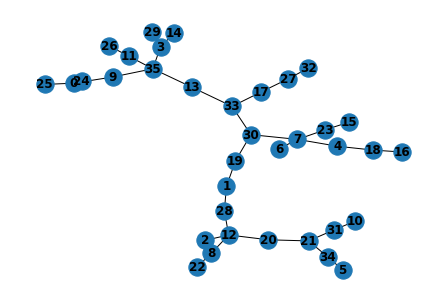

1得到L
[[1, 19, 28, 30, 33], [1, 12, 13, 19, 28, 30, 33], [1, 7, 12, 13, 19, 20, 28, 30, 33, 35], [1, 4, 7, 9, 12, 13, 17, 19, 20, 21, 28, 30, 33, 35], [0, 1, 3, 4, 7, 8, 9, 11, 12, 13, 17, 18, 19, 20, 21, 23, 27, 28, 30, 31, 33, 34, 35], [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]]


False
2.0 初始化前： 
source [-1. -1. -1. -1.]
R [[1, 19, 28, 30, 33]]


开始， 初始值是
在第几层： 0
source [-1. -1. -1. -1.]
R [[1, 19, 28, 30, 33]]
burned []
level_burned []
此时R长度是 5
更新值是
1 source [ 1. -1. -1. -1.]
2 R should remove [[19, 28, 30, 33]]
3 burned [1.0]
5 level_burned [[1.0]]
4 更新的burned [1.0, 28, 19]
5 更新的level_burned [[1.0], [28, 19]]
处理前的R [12, 13, 30, 33]
6 R updated [[19, 28, 30, 33], [12, 13, 30, 33]]
for  0 th round
结束向下走

开始， 初始值是
在第几层： 1
source [ 1. -1. -1. -1.]
R [[19, 28, 30, 33], [12, 13, 30, 33]]
burned [1.0, 28, 19]
level_burned [[1.0], [28, 19]]
此时R长度是 4
更新值是
1 source [ 1. 12. -1. -1.]
2 R should remove 

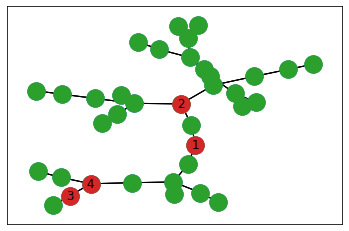

In [85]:
drawgraph(test_graph, 4, N)

In [78]:
L =  [0, 1.0, 2.0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35]

L_new = list(set(L))
print(L_new, "\n", len(L_new), len(L))

[0, 1.0, 2.0, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35] 
 36 36


In [82]:
A = [1, 2, 3]
B = [[1], [2]]
B.remove(B[1])
B

[[1]]